In [2]:
import numpy as np
data = np.load("../Figure 5 Shapley Save/shap_data_real.npz", allow_pickle=True)
real_dmaps = data["dmaps"]
real_defocus_shaps = data["defocus_shaps"]
real_rgb_shaps = data["rgb_shaps"]

In [3]:
import numpy as np
data = np.load("/media/NAS/USERS/minsun/Defocus/defocus/visualize/Figure 5 Shapley Save/shap_data_real.npz", allow_pickle=True)
real_dmaps = data["dmaps"]
real_defocus_shaps = data["defocus_shaps"]
real_rgb_shaps = data["rgb_shaps"]

In [4]:
real_dmaps.shape

(1000, 299, 299)

In [5]:
data = np.load("../Figure 5 Shapley Save/shap_data_fake_Face2Face.npz", allow_pickle=True)
fake_dmaps = data["dmaps"]
fake_defocus_shaps = data["defocus_shaps"]
fake_rgb_shaps = data["rgb_shaps"]

In [5]:
data = np.load("/media/NAS/USERS/minsun/Defocus/defocus/visualize/Figure 5 Shapley Save/shap_data_fake_Face2Face.npz", allow_pickle=True)
fake_dmaps = data["dmaps"]
fake_defocus_shaps = data["defocus_shaps"]
fake_rgb_shaps = data["rgb_shaps"]

In [6]:
fake_dmaps.shape

(1000, 299, 299)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Configuration
threshold = 0.1
max_samples = 1000
num_visualize = 5  # number of samples to visualize
fake_types = ["Deepfakes", "FaceSwap", "Face2Face", "NeuralTextures"]
base_path = "../Figure 5 Shapley Save"
real_file = os.path.join(base_path, "shap_data_real.npz")

# Directory for saving visualization results
save_dir = os.path.join(base_path, "visualized_masks")
os.makedirs(save_dir, exist_ok=True)

# Dictionary for storing statistics
all_stats = {}

# Start processing
for ftype in fake_types:
    fake_file = os.path.join(base_path, f"shap_data_fake_{ftype}.npz")

    # Load npz files
    real_data = np.load(real_file, allow_pickle=True)
    fake_data = np.load(fake_file, allow_pickle=True)
    print(real_data["dmaps"].shape)

    # Extract and stack dmaps
    real_maps = np.stack(real_data["dmaps"]).astype(np.float32)
    fake_maps = np.stack(fake_data["dmaps"]).astype(np.float32)

    num_samples = min(max_samples, real_maps.shape[0], fake_maps.shape[0])
    real_maps = real_maps[:num_samples]
    fake_maps = fake_maps[:num_samples]

    # Generate binary masks and compute statistics
    mask_counts = []
    for i in range(num_samples):
        real_map = np.squeeze(real_maps[i])
        fake_map = np.squeeze(fake_maps[i])
        mask = np.abs(fake_map - real_map) > threshold
        mask_counts.append(np.sum(mask))

        # Save visualization (first N samples only)
        if i < num_visualize:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(fake_map, cmap='gray')
            axes[0].set_title("Fake")
            axes[0].axis('off')

            axes[1].imshow(real_map, cmap='gray')
            axes[1].set_title("Real")
            axes[1].axis('off')

            axes[2].imshow(mask, cmap='gray')
            axes[2].set_title("Mask")
            axes[2].axis('off')

            plt.tight_layout()
            save_path = os.path.join(save_dir, f"{ftype}_sample_{i:03}.png")
            plt.savefig(save_path, dpi=300)
            plt.close()

    # Store statistics
    mask_counts = np.array(mask_counts)
    all_stats[ftype] = {
        "Average": np.mean(mask_counts),
        "Max": np.max(mask_counts),
        "Min": np.min(mask_counts),
        "Median": np.median(mask_counts)
    }

# Print summary results
print("Summary of Binary Mask Activation (|defocus_fake - defocus_real| > 0.1):")
print(f"{'Fake Type':<15} {'Average':>10} {'Max':>10} {'Min':>10} {'Median':>10}")
for ftype, stat in all_stats.items():
    print(f"{ftype:<15} {stat['Average']:10.2f} {stat['Max']:10} {stat['Min']:10} {stat['Median']:10}")


(1000, 299, 299)
(1000, 299, 299)
(1000, 299, 299)
(1000, 299, 299)
Summary of Binary Mask Activation (|defocus_fake - defocus_real| > 0.1):
Fake Type          Average        Max        Min     Median
Deepfakes          8949.28      76472         16     8092.0
FaceSwap           6797.20      75550          0     5547.0
Face2Face          7946.27      75015          0     7043.5
NeuralTextures     6923.42      29912          0     5474.5


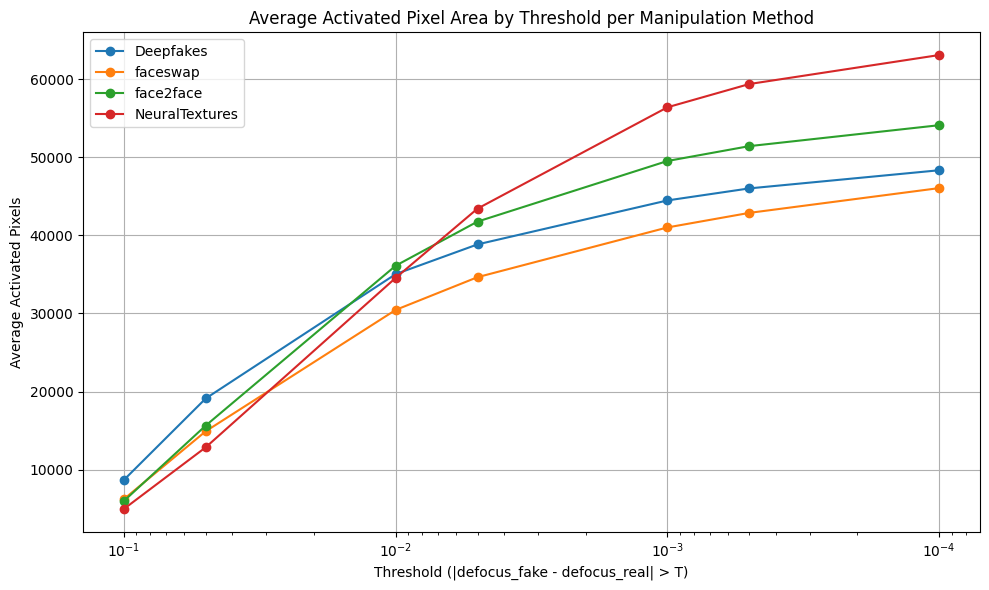


Threshold별 평균 활성화 픽셀 수:
           Deepfakes  faceswap  face2face  NeuralTextures
Threshold                                                
0.1000       8692.76   6238.70    5997.75         4979.90
0.0500      19119.33  14920.06   15649.32        12866.83
0.0100      35035.40  30453.13   36112.82        34555.31
0.0050      38838.15  34642.58   41756.60        43417.04
0.0010      44466.18  41010.18   49515.82        56388.70
0.0005      46005.39  42872.41   51415.07        59364.08
0.0001      48329.58  46045.66   54094.95        63076.58


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# 설정
thresholds = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
fake_types = ["Deepfakes", "faceswap", "face2face", "NeuralTextures"]
base_path = "../Figure 5 Shapley Save"
real_file = os.path.join(base_path, "shap_data_real.npz")
max_samples = 6400

# 결과 저장
activation_stats = {ftype: [] for ftype in fake_types}

# 로딩 및 비교 함수
def load_maps(real_file, fake_file, max_samples=1000):
    real_data = np.load(real_file, allow_pickle=True)
    fake_data = np.load(fake_file, allow_pickle=True)
    real_maps = np.stack(real_data["dmaps"]).astype(np.float32)
    fake_maps = np.stack(fake_data["dmaps"]).astype(np.float32)
    num_samples = min(max_samples, real_maps.shape[0], fake_maps.shape[0])
    return real_maps[:num_samples], fake_maps[:num_samples]

# 통계 계산
for ftype in fake_types:
    fake_file = os.path.join(base_path, f"shap_data_fake_{ftype}.npz")
    real_maps, fake_maps = load_maps(real_file, fake_file, max_samples)

    for t in thresholds:
        mask_counts = []
        for i in range(real_maps.shape[0]):
            real_map = np.squeeze(real_maps[i])
            fake_map = np.squeeze(fake_maps[i])
            diff = np.abs(fake_map - real_map)
            mask = diff > t
            mask_counts.append(np.sum(mask))
        activation_stats[ftype].append(np.mean(mask_counts))

# 시각화
plt.figure(figsize=(10, 6))
for ftype in fake_types:
    plt.plot(thresholds, activation_stats[ftype], label=ftype, marker='o')

plt.xlabel("Threshold (|defocus_fake - defocus_real| > T)")
plt.ylabel("Average Activated Pixels")
plt.title("Average Activated Pixel Area by Threshold per Manipulation Method")
plt.xscale("log")
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend()
plt.tight_layout()

# PNG 파일로 저장 (DPI 300)
save_path = "activated_pixel_area_vs_threshold.png"
plt.savefig(save_path, dpi=300)
plt.show()

# 결과를 표로 정리
df = pd.DataFrame(activation_stats, index=thresholds)
df.index.name = "Threshold"
print("\nThreshold별 평균 활성화 픽셀 수:")
print(df.round(2))
